In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix

In [7]:
# Download and unpack the training set and the test set

! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip -P data
! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip -P data
! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data
! unzip data/GTSRB_Final_Test_Images.zip -d data
! unzip data/GTSRB_Final_Test_GT.zip -d data

# Move the test set to data/test

! mkdir data/test
! mv data/GTSRB/Final_Test/Images/*.ppm data/test

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data

--2018-04-05 22:31:00--  http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘data/GTSRB_Final_Training_Images.zip’

p                     0%[                    ]   1.93M  26.7KB/s    eta 2h 50m ^C
--2018-04-05 22:32:16--  http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘data/GTSRB_Final_Test_Images.zip’

        GTSRB_Final   0%[                    ]  26.57K  59.4KB/s               ^C
134.147.122.15
Connecting to benchmark.ini.rub.de (b

In [3]:
Annotation = namedtuple('Annotation', ['filename', 'label'])
def read_annotations(filename):
    annotations = []
    
    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
            
    return annotations

In [4]:
def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

def copy_files(label, filenames, source, destination, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    for filename in filenames:
        destination_path = os.path.join(label_path, filename)
        if not os.path.exists(destination_path):
            func(os.path.join(source, format(label, '05d'), filename), destination_path)

def split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    """
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
        
    if not os.path.exists(all_path):
        os.makedirs(all_path)
    
    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        validation_size = int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        copy_files(label, filenames, source_path, all_path, move=False)
        copy_files(label, train_filenames, source_path, train_path, move=True)
        copy_files(label, validation_filenames, source_path, validation_path, move=True)

In [5]:
path = 'data'
source_path = os.path.join(path, 'GTSRB/Final_Training/Images')
train_path = os.path.join(path, 'train')
validation_path = os.path.join(path, 'valid')
all_path = os.path.join(path, 'all')
validation_fraction = 0.2
split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction)

In [6]:
test_annotations = read_annotations('data/GT-final_test.csv')

# Exploratory analysis

In [7]:
classes = pd.read_csv('data/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

In [8]:
arch=resnet34
sz = 96
data = ImageClassifierData.from_paths(path, tfms=tfms_from_model(arch, sz), test_name='test')

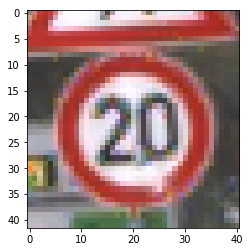

In [9]:
plt.imshow(load_img_id(data.val_ds, 1, path))
plt.show()

In [10]:
y = data.trn_ds.y

In [11]:
print(y[:10])

[0 0 0 0 0 0 0 0 0 0]


In [12]:
from collections import Counter

label_counts = Counter(y).most_common()

for l, c in label_counts:
    print(c, '\t', data.classes[l], '\t', class_names[data.classes[l]])

1800 	 1 	 Speed limit (30km/h)
1800 	 2 	 Speed limit (50km/h)
1740 	 13 	 Yield
1680 	 12 	 Priority road
1680 	 38 	 Keep right
1620 	 10 	 No passing for vechiles over 3.5 metric tons
1590 	 4 	 Speed limit (70km/h)
1500 	 5 	 Speed limit (80km/h)
1200 	 25 	 Road work
1200 	 9 	 No passing
1170 	 7 	 Speed limit (100km/h)
1140 	 3 	 Speed limit (60km/h)
1140 	 8 	 Speed limit (120km/h)
1080 	 11 	 Right-of-way at the next intersection
960 	 18 	 General caution
960 	 35 	 Ahead only
900 	 17 	 No entry
630 	 14 	 Stop
630 	 31 	 Wild animals crossing
569 	 33 	 Turn right ahead
510 	 15 	 No vechiles
480 	 26 	 Traffic signals
450 	 28 	 Children crossing
420 	 23 	 Slippery road
360 	 16 	 Vechiles over 3.5 metric tons prohibited
360 	 30 	 Beware of ice/snow
360 	 34 	 Turn left ahead
360 	 6 	 End of speed limit (80km/h)
330 	 22 	 Bumpy road
330 	 36 	 Go straight or right
300 	 20 	 Dangerous curve to the right
300 	 40 	 Roundabout mandatory
270 	 21 	 Double curve
240 	 24 

0 Speed limit (20km/h)


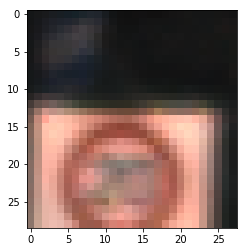

1 Speed limit (30km/h)


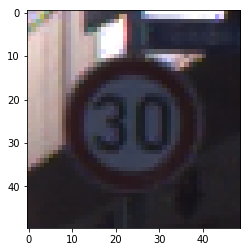

2 Speed limit (50km/h)


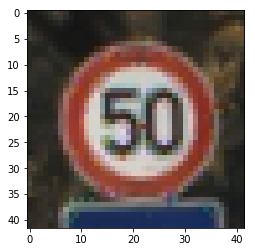

3 Speed limit (60km/h)


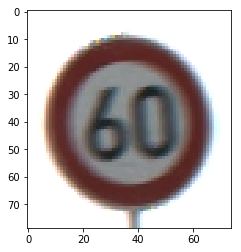

4 Speed limit (70km/h)


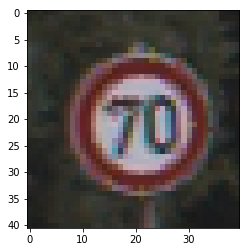

5 Speed limit (80km/h)


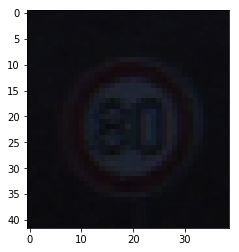

6 End of speed limit (80km/h)


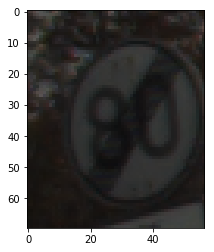

7 Speed limit (100km/h)


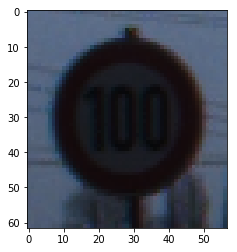

8 Speed limit (120km/h)


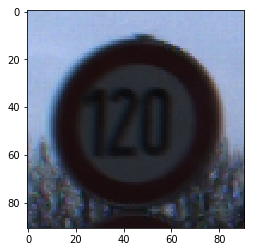

9 No passing


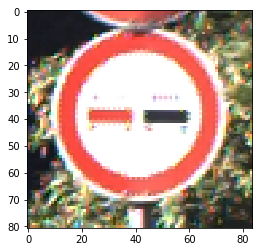

10 No passing for vechiles over 3.5 metric tons


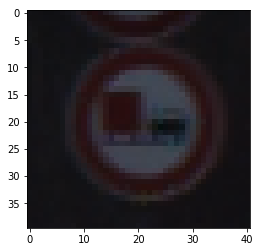

11 Right-of-way at the next intersection


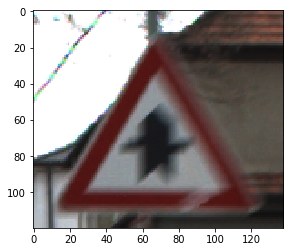

12 Priority road


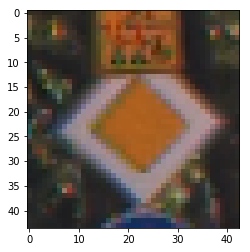

13 Yield


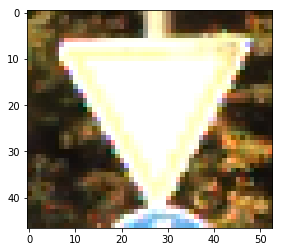

14 Stop


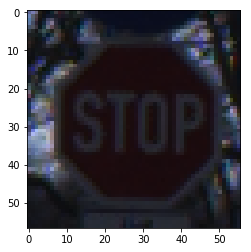

15 No vechiles


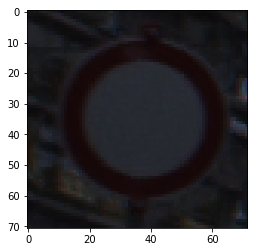

16 Vechiles over 3.5 metric tons prohibited


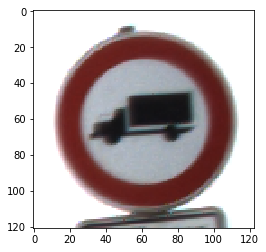

17 No entry


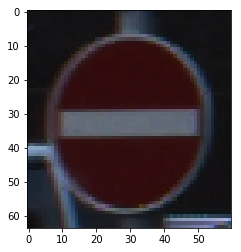

18 General caution


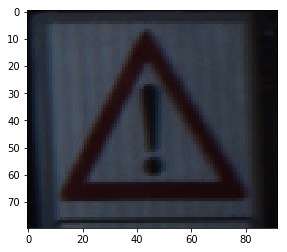

19 Dangerous curve to the left


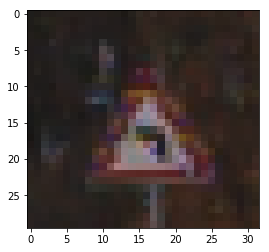

20 Dangerous curve to the right


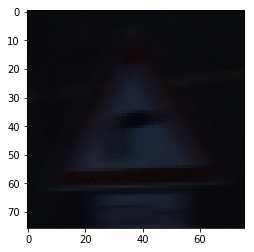

21 Double curve


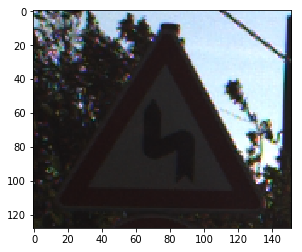

22 Bumpy road


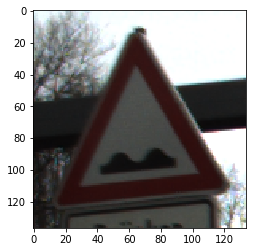

23 Slippery road


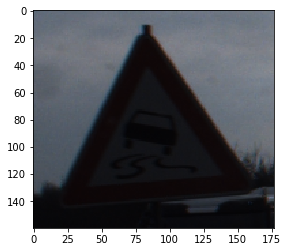

24 Road narrows on the right


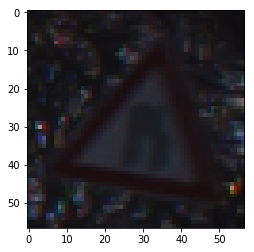

25 Road work


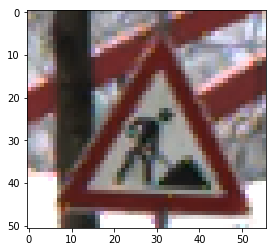

26 Traffic signals


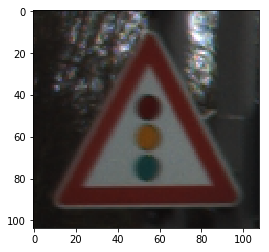

27 Pedestrians


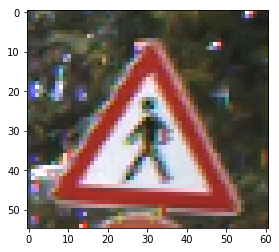

28 Children crossing


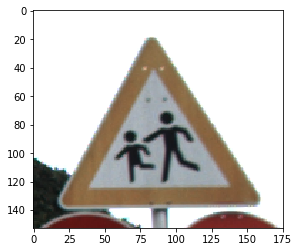

29 Bicycles crossing


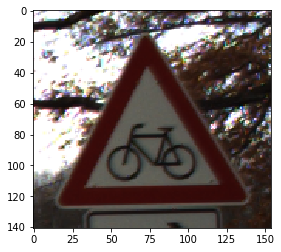

30 Beware of ice/snow


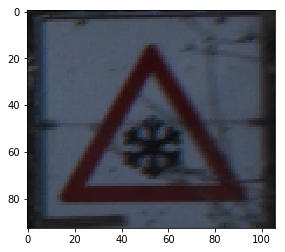

31 Wild animals crossing


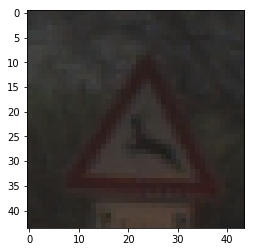

32 End of all speed and passing limits


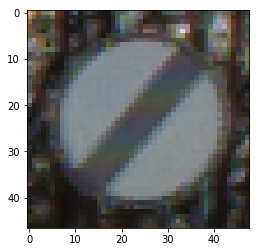

33 Turn right ahead


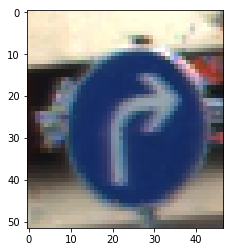

34 Turn left ahead


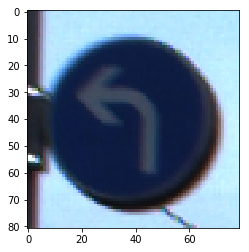

35 Ahead only


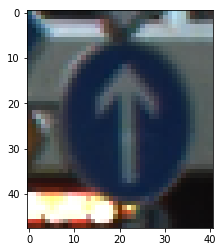

36 Go straight or right


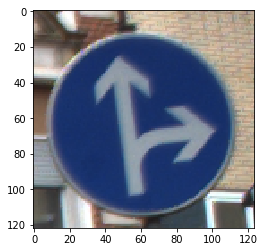

37 Go straight or left


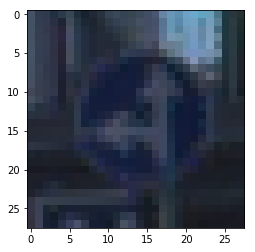

38 Keep right


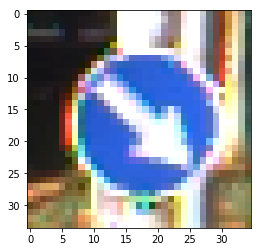

39 Keep left


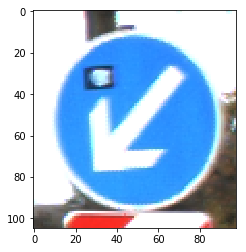

40 Roundabout mandatory


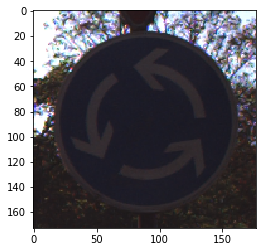

41 End of no passing


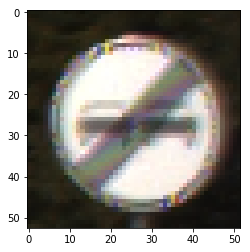

42 End of no passing by vechiles over 3.5 metric tons


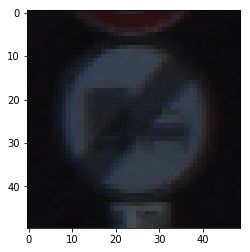

In [13]:
for label in sorted([l for l, c in label_counts], key=lambda p: int(data.classes[p])):
    i = [i for i, l in enumerate(y) if l == label][0]
    print(data.classes[y[i]], class_names[data.classes[y[i]]])
    plt.imshow(load_img_id(data.trn_ds, i, path))
    plt.show()

## Image sizes

In [14]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = 'data/all/0'

files = os.listdir(folder)
sizes = []

for file in files:
    filename = os.path.join(folder, file)
    img = cv2.imread(filename, flags)
    sizes.append(max(img.shape[0], img.shape[1]))

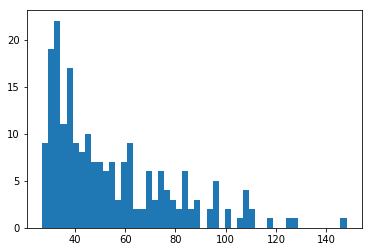

In [15]:
plt.hist(sizes, bins=50)
plt.show()

# Image lighting

Let's try histogram equalization to improve constrast.

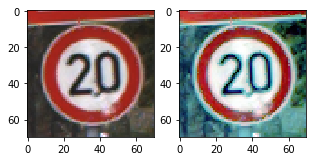

(70, 70, 3)


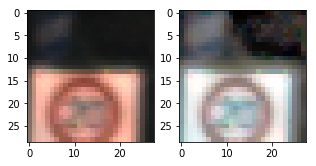

(29, 28, 3)


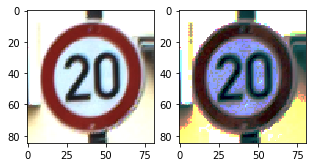

(85, 81, 3)


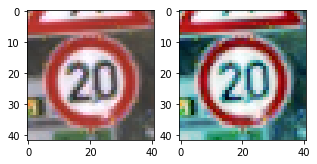

(42, 41, 3)


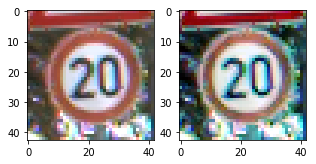

(43, 42, 3)


In [16]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = 'data/all/0'

files = os.listdir(folder)
for i in range(5):
    f = plt.figure(figsize=(5, 5))
    
    filename = os.path.join(folder, files[i])
    img = cv2.imread(filename, flags)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sp = f.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
    
    
    sp = f.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.show()
    
    print(img.shape)

In [17]:
# Normal version

def open_image_normal(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The numpy array representation of the image in the RGB format
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            return cv2.cvtColor(cv2.imread(fn, flags), cv2.COLOR_BGR2RGB).astype(np.float32)/255
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [18]:
# Histogram equalization

def open_image_hist_eq(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The numpy array representation of the image in the RGB format
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            img = cv2.cvtColor(cv2.imread(fn, flags), cv2.COLOR_BGR2RGB)
            img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
            return img.astype(np.float32)/255
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

Uncomment the 2nd line below to apply histogram equalization to fastai dataset code.

In [19]:
open_image = open_image_normal
#open_image = open_image_hist_eq

## Fastai fixes

There seems to be a bug in fastai: augmented training set images are not shuffled.
We have to fix it here by redefining ImageData class. We also need to redefine ImageClassifierData because it uses ImageData.
I'll make a pull request to fix it in the library later.

In [20]:
class ImageData(ModelData):
    def __init__(self, path, datasets, bs, num_workers, classes):
        trn_ds,val_ds,fix_ds,aug_ds,test_ds,test_aug_ds = datasets
        self.path,self.bs,self.num_workers,self.classes = path,bs,num_workers,classes
        self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl,self.test_dl,self.test_aug_dl = [
            self.get_dl(ds,shuf) for ds,shuf in [
                (trn_ds,True),(val_ds,False),(fix_ds,False),(aug_ds,True),
                (test_ds,False),(test_aug_ds,False)
            ]
        ]
        print('augmentated training samples are shuffled')

    def get_dl(self, ds, shuffle):
        if ds is None: return None
        return ModelDataLoader.create_dl(ds, batch_size=self.bs, shuffle=shuffle,
            num_workers=self.num_workers, pin_memory=False)

    @property
    def sz(self): return self.trn_ds.sz
    @property
    def c(self): return self.trn_ds.c

    def resized(self, dl, targ, new_path):
        return dl.dataset.resize_imgs(targ,new_path) if dl else None

    def resize(self, targ, new_path):
        new_ds = []
        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
        else: dls += [None,None]
        t = tqdm_notebook(dls)
        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
        t.close()
        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)

In [21]:
class ImageClassifierData(ImageData):
    @property
    def is_multi(self): return self.trn_dl.dataset.is_multi

    @staticmethod
    def get_ds(fn, trn, val, tfms, test=None, **kwargs):
        res = [
            fn(trn[0], trn[1], tfms[0], **kwargs), # train
            fn(val[0], val[1], tfms[1], **kwargs), # val
            fn(trn[0], trn[1], tfms[1], **kwargs), # fix
            fn(val[0], val[1], tfms[0], **kwargs)  # aug
        ]
        if test is not None:
            test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], **kwargs), # test
                fn(test, test_lbls, tfms[0], **kwargs)  # test_aug
            ]
        else: res += [None,None]
        return res

    @classmethod
    def from_arrays(cls, path, trn, val, bs=64, tfms=(None,None), classes=None, num_workers=4, test=None):
        """ Read in images and their labels given as numpy arrays

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            trn: a tuple of training data matrix and target label/classification array (e.g. `trn=(x,y)` where `x` has the
                shape of `(5000, 784)` and `y` has the shape of `(5000,)`)
            val: a tuple of validation data matrix and target label/classification array.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            classes: a list of all labels/classifications
            num_workers: a number of workers
            test: a matrix of test data (the shape should match `trn[0]`)

        Returns:
            ImageClassifierData
        """
        datasets = cls.get_ds(ArraysIndexDataset, trn, val, tfms, test=test)
        return cls(path, datasets, bs, num_workers, classes=classes)

    @classmethod
    def from_paths(cls, path, bs=64, tfms=(None,None), trn_name='train', val_name='valid', test_name=None, num_workers=8):
        """ Read in images and their labels given as sub-folder names

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            trn_name: a name of the folder that contains training images.
            val_name:  a name of the folder that contains validation images.
            test_name:  a name of the folder that contains test images.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        trn,val = [folder_source(path, o) for o in (trn_name, val_name)]
        test_fnames = read_dir(path, test_name) if test_name else None
        datasets = cls.get_ds(FilesIndexArrayDataset, trn, val, tfms, path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=trn[2])

    @classmethod
    def from_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
               val_idxs=None, suffix='', test_name=None, continuous=False, skip_header=True, num_workers=8):
        """ Read in images and their labels given as a CSV file.

        This method should be used when training image labels are given in an CSV file as opposed to
        sub-directories with label names.

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            folder: a name of the folder in which training images are contained.
            csv_fname: a name of the CSV file which contains target labels.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
                If None, default arguments to get_cv_idxs are used.
            suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                    extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
            test_name: a name of the folder which contains test images.
            continuous: TODO
            skip_header: skip the first row of the CSV file.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        fnames,y,classes = csv_source(folder, csv_fname, skip_header, suffix, continuous=continuous)

        val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
        ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

        test_fnames = read_dir(path, test_name) if test_name else None
        if continuous:
            f = FilesIndexArrayRegressionDataset
        else:
            f = FilesIndexArrayDataset if len(trn_y.shape)==1 else FilesNhotArrayDataset
        datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                               path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=classes)

# Image augmentation

Here we can change image augmentation parameters and see how augmented images look like.

In [20]:
# Look at examples of image augmentation
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

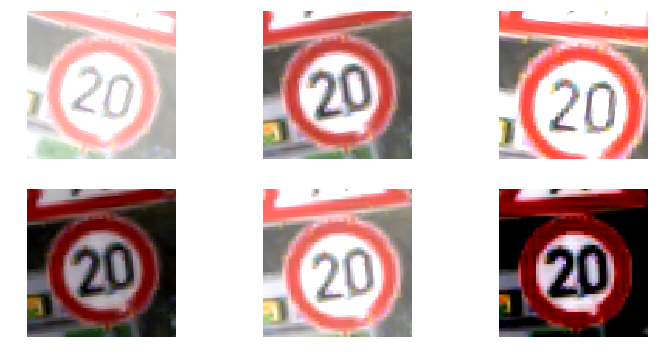

In [21]:
bs = 256

aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [27]:
??tfms_from_model

In [26]:
??ImageClassifierData.from_paths

# Training

In [22]:
# Create a learner
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [23]:
wd=5e-4

## Searching for a good starting learning rate

In [24]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [26]:
torch.cuda.is_available()

True

In [27]:
torch.backends.cudnn.enabled

True

In [28]:
learn.lr_find()

  0%|          | 0/125 [00:00<?, ?it/s]


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 95%|█████████▌| 119/125 [06:54<00:20,  3.48s/it, loss=13.2]


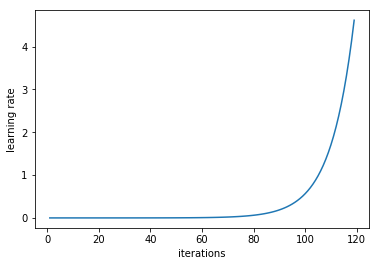

In [29]:
learn.sched.plot_lr()

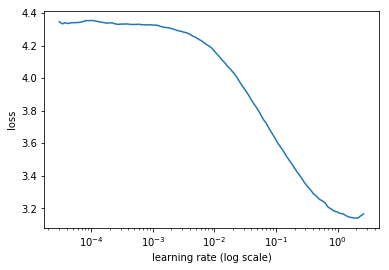

In [30]:
learn.sched.plot()

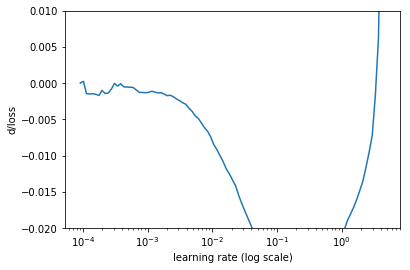

In [31]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.02, 0.01))

## Training with LR 0.01 for 1 epoch

In [32]:
learn.fit(0.01, 1, wds=wd)
#learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      2.522164   1.623658   0.506173  



[array([1.62366]), 0.5061728392445338]

In [33]:
learn.unfreeze()
learn.lr_find()

 94%|█████████▎| 117/125 [11:29<00:47,  5.89s/it, loss=45.2]

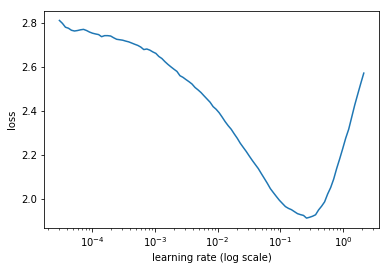

In [34]:
learn.sched.plot()

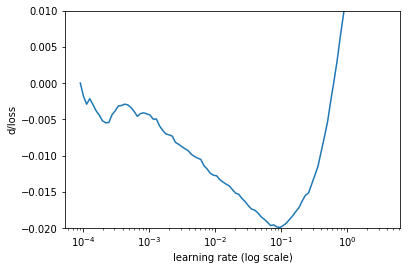

In [35]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.02, 0.01))

## Unfreeze and train with LR 0.01 for 3 epochs

In [36]:
learn.unfreeze()
learn.fit(0.01, 3, wds=wd)
#learn.fit(0.01, 3)

  0%|          | 0/125 [00:00<?, ?it/s]                     


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.968059   0.136755   0.960494  
    1      0.736561   0.062827   0.979561                    
    2      0.681203   0.074317   0.979561                    



[array([0.07432]), 0.9795610425240054]

In [37]:
learn.save('1')

In [38]:
learn.lr_find()

 90%|█████████ | 113/125 [11:24<01:12,  6.06s/it, loss=4.4]  

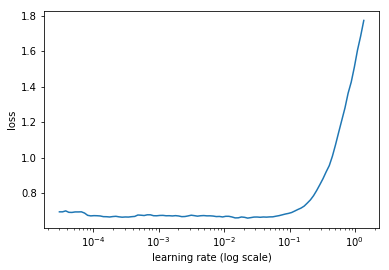

In [39]:
learn.sched.plot()

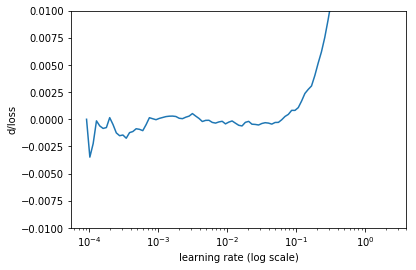

In [40]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.01, 0.01))

## Train for a few cycles

In [41]:
learn.load('1')

In [42]:
lr=0.01

In [43]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2, wds=wd)
#learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

  0%|          | 0/125 [00:00<?, ?it/s]                    


Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.622149   0.037978   0.988752  
    1      0.627626   0.048214   0.985871                    
    2      0.600393   0.037139   0.9893                      
    3      0.617624   0.052129   0.984636                    
    4      0.605967   0.031265   0.991221                    
    5      0.576781   0.032817   0.990123                    
    6      0.569305   0.031403   0.990809                    
    7      0.597959   0.041848   0.987654                    
    8      0.593517   0.053981   0.984362                    
    9      0.586398   0.047186   0.986831                    
    10     0.569058   0.033855   0.989712                    
    11     0.544819   0.029406   0.992044                    
    12     0.553008   0.033332   0.990535                    
    13     0.541995   0.033281   0.990809                    
    14     0.546431   0.028831   0.992181                    



[array([0.02883]), 0.9921810699588477]

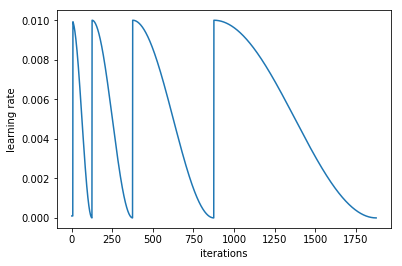

In [44]:
learn.sched.plot_lr()

In [45]:
learn.save('2')

In [46]:
learn.lr_find()

 89%|████████▉ | 111/125 [06:53<00:52,  3.73s/it, loss=2.21] 

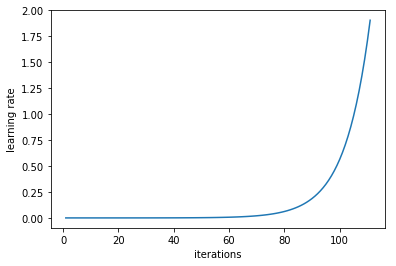

In [47]:
learn.sched.plot_lr()

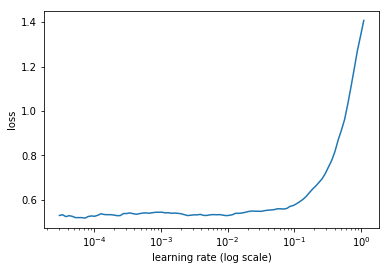

In [48]:
learn.sched.plot()

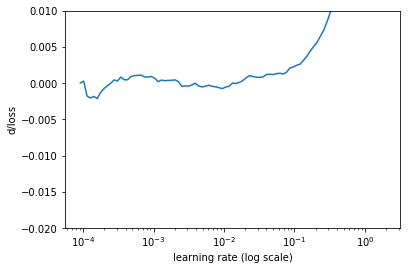

In [49]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.02, 0.01))

## Error analysis

In [50]:
log_preds,y = learn.predict_with_targs()
preds = np.exp(log_preds)
pred_labels = np.argmax(preds, axis=1)

In [51]:
cm = confusion_matrix(y, pred_labels)

In [52]:
cm

array([[ 30,   0,   0, ...,   0,   0,   0],
       [  2, 418,   0, ...,   0,   0,   0],
       [  0,   0, 390, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 268,   0,   0],
       [  0,   0,   0, ...,   0, 270,   0],
       [  0,   0,   0, ...,   0,   0, 270]])

In [53]:
results = ImageModelResults(data.val_ds, log_preds)

### Most incorrect

In [54]:
incorrect = [i for i in range(len(pred_labels)) if pred_labels[i] != y[i]]
c = Counter([(y[i], class_names[data.classes[y[i]]]) for i in incorrect])
c.most_common(20)

[((7, 'No vechiles'), 18),
 ((22, 'Bicycles crossing'), 12),
 ((11, 'Dangerous curve to the left'), 4),
 ((19, 'Traffic signals'), 4),
 ((34, 'Speed limit (70km/h)'), 4),
 ((12, 'Speed limit (50km/h)'), 3),
 ((17, 'Road narrows on the right'), 3),
 ((26, 'End of all speed and passing limits'), 3),
 ((1, 'Speed limit (30km/h)'), 2),
 ((40, 'Speed limit (100km/h)'), 2),
 ((16, 'Slippery road'), 1),
 ((24, 'Beware of ice/snow'), 1)]

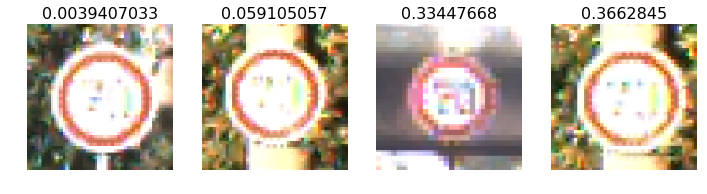

In [55]:
results.plot_most_incorrect(34)

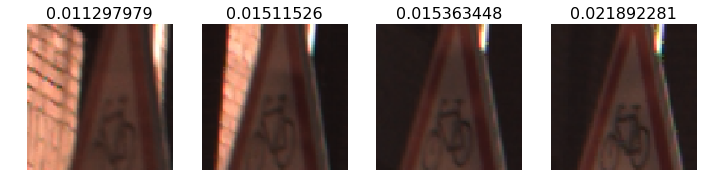

In [56]:
results.plot_most_incorrect(22)

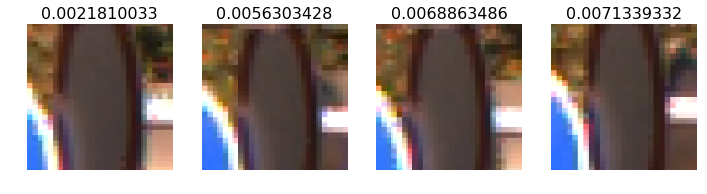

In [57]:
results.plot_most_incorrect(7)

### Most correct

In [63]:
correct = [i for i in range(len(pred_labels)) if pred_labels[i] == y[i]]
c1 = Counter([(y[i], class_names[data.classes[y[i]]]) for i in correct])
c1.most_common(20)

[((12, 'Speed limit (50km/h)'), 447),
 ((4, 'Priority road'), 420),
 ((5, 'Yield'), 420),
 ((1, 'Speed limit (30km/h)'), 418),
 ((2, 'No passing for vechiles over 3.5 metric tons'), 390),
 ((32, 'Keep right'), 390),
 ((34, 'Speed limit (70km/h)'), 386),
 ((38, 'Speed limit (80km/h)'), 360),
 ((18, 'Road work'), 300),
 ((23, 'Speed limit (60km/h)'), 270),
 ((41, 'Speed limit (120km/h)'), 270),
 ((42, 'No passing'), 270),
 ((40, 'Speed limit (100km/h)'), 268),
 ((3, 'Right-of-way at the next intersection'), 240),
 ((10, 'General caution'), 240),
 ((29, 'Ahead only'), 240),
 ((9, 'No entry'), 210),
 ((6, 'Stop'), 150),
 ((25, 'Wild animals crossing'), 150),
 ((27, 'Turn right ahead'), 120)]

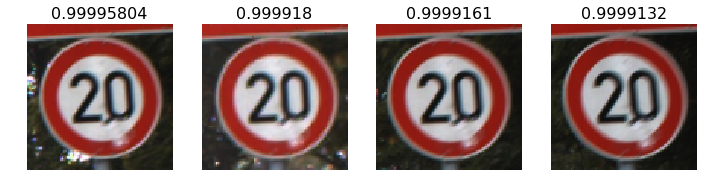

In [58]:
results.plot_most_correct(0)

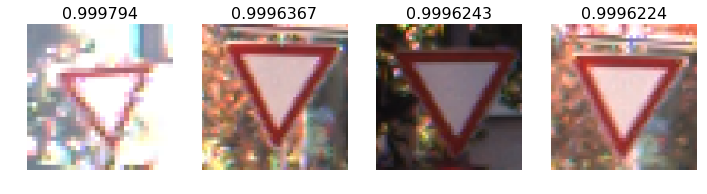

In [59]:
results.plot_most_correct(5)

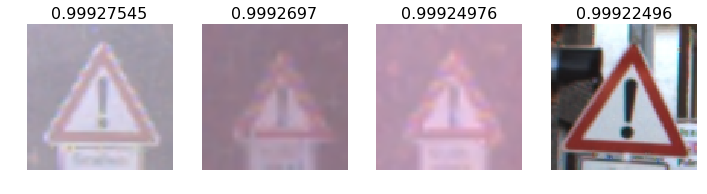

In [2672]:
results.plot_most_correct(10)

### Most uncertain

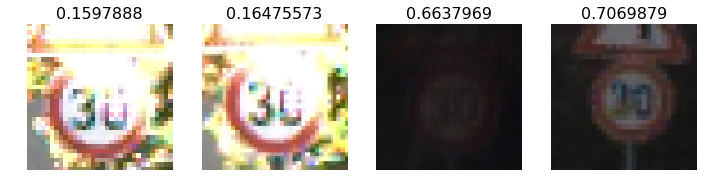

In [64]:
results.plot_most_uncertain(1)

## Test time augmentation (TTA)

In [65]:
log_preds,y = learn.TTA(n_aug=20)
preds = np.mean(np.exp(log_preds),0)

In [66]:
accuracy_np(preds, y)

0.9936899862825789

# Retrain on the training set + validation set

Validation loss/accuracy won't be indicative of the model performance because the validation set is a subset of the training set now.

In [67]:
arch = resnet34
sz = 96
bs = 256
wd = 5e-4

In [68]:
aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, trn_name='all', val_name='valid', test_name='test', bs=bs)

In [69]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [70]:
lr = 0.01

In [71]:
learn.fit(lr, 1, wds=wd)

  0%|          | 0/154 [00:00<?, ?it/s]


Exception in thread Thread-28:
Traceback (most recent call last):
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srikanth/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      2.359925   1.35222    0.577641  



[array([1.35222]), 0.5776406035011197]

In [72]:
learn.unfreeze()
learn.fit(lr, 3, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.874798   0.055804   0.985597  
    1      0.710839   0.02101    0.995336                    
    2      0.664318   0.010049   0.997668                    



[array([0.01005]), 0.9976680384087792]

In [73]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.624328   0.004338   0.99904   
    1      0.632783   0.004392   0.999451                    
    2      0.625896   0.003961   0.999177                    
    3      0.61052    0.014452   0.995885                    
    4      0.603156   0.003497   0.999177                    
    5      0.597853   0.001718   1.0                         
    6      0.561756   0.001717   1.0                         
    7      0.580494   0.003444   0.999451                    
    8      0.594926   0.003027   0.999588                    
    9      0.56835    0.001679   1.0                         
    10     0.559037   0.001865   0.999863                    
    11     0.54841    0.002163   0.999588                    
    12     0.536753   0.001367   1.0                         
    13     0.539082   0.001288   1.0                         
    14     0.529881   0.001338   1.0                         



[array([0.00134]), 1.0]

# Testing on the test set

In [74]:
true_test_labels = {a.filename: a.label for a in test_annotations}
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(true_test_labels[filename]) for filename in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [75]:
log_preds = learn.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

0.9904196357878068

In [76]:
log_preds,_ = learn.TTA(n_aug=20, is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)

0.9936658749010293

# Analyze test results

In [77]:
pred_labels = np.argmax(preds, axis=1)

In [78]:
incorrect = [i for i in range(len(pred_labels)) if pred_labels[i] != y_true[i]]

Road narrows on the right Pedestrians 0.17832424 0.34881192


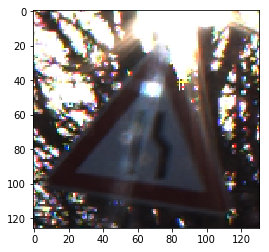

General caution Pedestrians 0.35992864 0.4766249


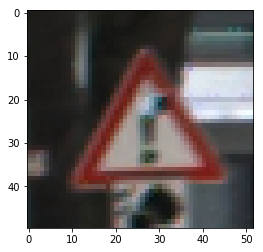

Right-of-way at the next intersection Beware of ice/snow 0.35714504 0.38648772


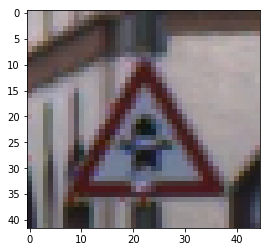

Beware of ice/snow Right-of-way at the next intersection 0.25261256 0.46694347


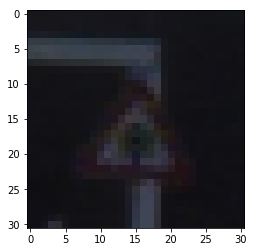

Speed limit (100km/h) Speed limit (120km/h) 0.060270414 0.77233803


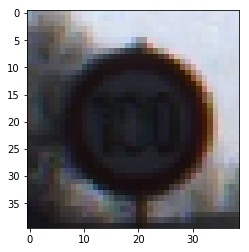

Speed limit (60km/h) Speed limit (80km/h) 0.2642811 0.57859457


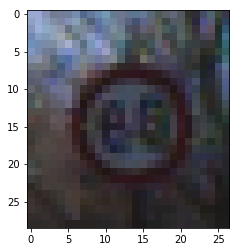

General caution Dangerous curve to the left 0.27932265 0.3060069


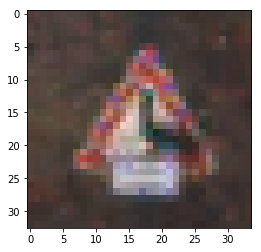

Beware of ice/snow Right-of-way at the next intersection 0.19977576 0.3843485


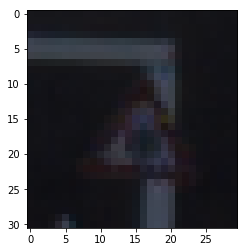

No entry Stop 0.24440046 0.6040071


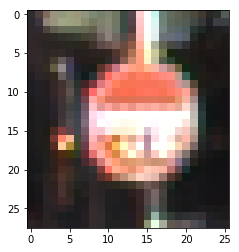

Beware of ice/snow Right-of-way at the next intersection 0.087953 0.16694206


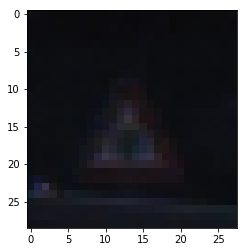

In [79]:
for i in range(0,10):
    print(class_names[data.classes[y_true[incorrect[i]]]], class_names[data.classes[pred_labels[incorrect[i]]]], 
          preds[incorrect[i], y_true[incorrect[i]]], preds[incorrect[i], pred_labels[incorrect[i]]])
    plt.imshow(load_img_id(data.test_ds, incorrect[i], path))
    plt.show()

In [80]:
cm = confusion_matrix(y_true, pred_labels)

In [81]:
np.savetxt(os.path.join(path, 'confusion_matrix.tsv'), cm, delimiter='\t')

In [82]:
c = Counter([class_names[data.classes[y_true[i]]] for i in incorrect])
c.most_common(20)

[('General caution', 23),
 ('Beware of ice/snow', 10),
 ('Speed limit (60km/h)', 9),
 ('Right-of-way at the next intersection', 7),
 ('Speed limit (80km/h)', 4),
 ('No entry', 3),
 ('Speed limit (70km/h)', 3),
 ('Roundabout mandatory', 3),
 ('Traffic signals', 3),
 ('End of speed limit (80km/h)', 2),
 ('Yield', 2),
 ('Speed limit (120km/h)', 2),
 ('Road work', 2),
 ('End of no passing', 2),
 ('Road narrows on the right', 1),
 ('Speed limit (100km/h)', 1),
 ('Keep right', 1),
 ('Bumpy road', 1),
 ('Speed limit (50km/h)', 1)]

In [83]:
c = Counter([class_names[data.classes[pred_labels[i]]] for i in incorrect])
c.most_common(20)

[('Pedestrians', 12),
 ('Beware of ice/snow', 9),
 ('Speed limit (80km/h)', 9),
 ('Right-of-way at the next intersection', 6),
 ('Speed limit (60km/h)', 6),
 ('Road work', 5),
 ('Wild animals crossing', 4),
 ('Double curve', 4),
 ('Dangerous curve to the left', 3),
 ('Stop', 3),
 ('Traffic signals', 3),
 ('Speed limit (50km/h)', 2),
 ('Ahead only', 2),
 ('Priority road', 2),
 ('Speed limit (70km/h)', 2),
 ('No passing', 2),
 ('Speed limit (120km/h)', 1),
 ('Go straight or right', 1),
 ('Keep right', 1),
 ('Speed limit (100km/h)', 1)]

# Create a submission file

In [84]:
pred_labels = np.argmax(preds, axis=1)
pred_labels.shape

(12630,)

12464.ppm 4 Speed limit (70km/h)


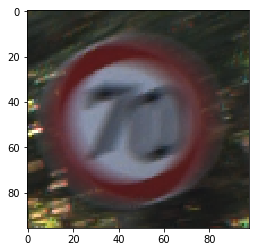

04395.ppm 38 Keep right


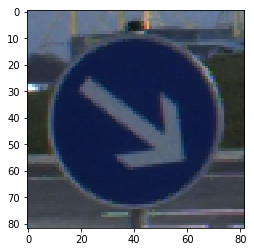

03672.ppm 33 Turn right ahead


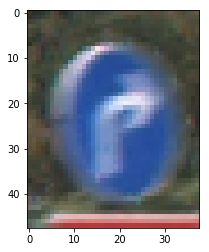

03335.ppm 1 Speed limit (30km/h)


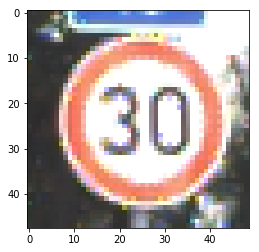

04835.ppm 10 No passing for vechiles over 3.5 metric tons


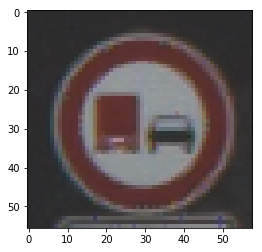

08314.ppm 12 Priority road


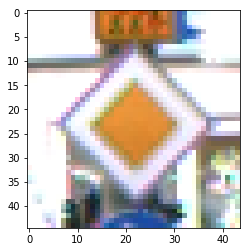

04911.ppm 17 No entry


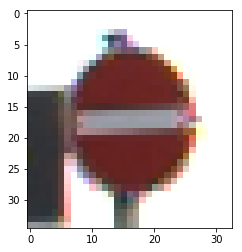

02648.ppm 11 Right-of-way at the next intersection


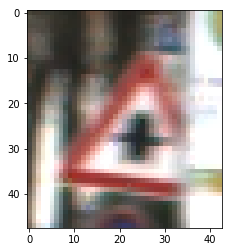

04909.ppm 8 Speed limit (120km/h)


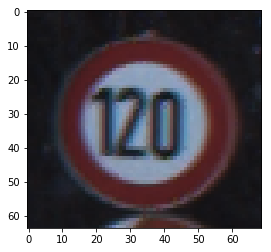

00741.ppm 1 Speed limit (30km/h)


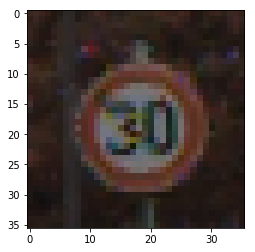

In [85]:
for i in range(10):
    class_id = data.classes[pred_labels[i]]
    filename = data.test_ds.fnames[i].split('/')[1]
    print(filename, class_id, class_names[class_id])
    plt.imshow(load_img_id(data.test_ds, i, path))
    plt.show()

In [86]:
with open('data/submission.csv', 'w') as f:
    for i in range(pred_labels.shape[0]):
        filename = data.test_ds.fnames[i].split('/')[1]
        f.write('{};{}\n'.format(filename, data.classes[pred_labels[i]]))

In [2699]:
from IPython.display import FileLink
FileLink('data/submission.csv')

/notebooks/sd/GTSRB/data/submission.csv